In [41]:
import os
import shutil
import pandas as pd

In [67]:
image_folder = 'C:\\Users\\alexb\\Desktop\\spot-the-mask\\images'
train_images = 'C:\\Users\\alexb\\Desktop\\spot-the-mask\\train_images'
no_mask_folder = 'C:\\Users\\alexb\\Desktop\\spot-the-mask\\train_images\\0'
mask_folder = 'C:\\Users\\alexb\\Desktop\\spot-the-mask\\train_images\\1'
contest_data_folder = 'C:\\Users\\alexb\\Desktop\\spot-the-mask\\what-to-predict' # what to predict
csv_file = 'C:\\Users\\alexb\\Desktop\\spot-the-mask\\train_labels.csv'

In [45]:
os.makedirs(train_images, exist_ok = True)
os.makedirs(no_mask_folder, exist_ok=True)
os.makedirs(mask_folder, exist_ok=True)
os.makedirs(contest_data_folder, exist_ok = True)

In [47]:
df = pd.read_csv(csv_file)

In [49]:
labeled_images = set(df['image'])
# labeled_images

In [51]:
for image_name in os.listdir(image_folder):
    image_path = os.path.join(image_folder, image_name)

    if not os.path.isfile(image_path):
        continue

    if image_name in labeled_images:
        label = df.loc[df['image'] == image_name, 'target'].values[0]

        if label == 0:
            dest_folder = no_mask_folder
        elif label == 1:
            dest_folder = mask_folder
        else:
            continue
    else:
        dest_folder = contest_data_folder
    shutil.move(image_path, os.path.join(dest_folder, image_name))

In [61]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm

In [63]:
class MaskDataset(Dataset):
    def __init__(self, data_dir, transform = None):
        self.data = ImageFolder(data_dir, transform = transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

    @property
    def classes(self):
        return self.data.classes

In [69]:
dataset = MaskDataset(data_dir = train_images)

In [71]:
len(dataset)

1308

1


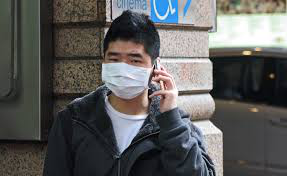

In [73]:
image, label = dataset[1000]
print(label)
image

In [75]:
# mapping classes, 0 - no mask, 1 - mask

data_dir = train_images
target_to_class = {v: k for k, v in ImageFolder(data_dir).class_to_idx.items()}
print(target_to_class)

{0: '0', 1: '1'}


In [77]:
# applying basic transforms to image, then image to tensor

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

In [79]:
data_dir = train_images
dataset = MaskDataset(data_dir = data_dir, transform = transform)

In [81]:


image, label = dataset[1000]
image.shape

torch.Size([3, 128, 128])

In [83]:
dataloader = DataLoader(dataset, batch_size = 32, shuffle = True)

In [85]:
for images, labels in dataloader:
  print(images.shape)
  print(labels.shape)
  break

torch.Size([32, 3, 128, 128])
torch.Size([32])


In [87]:
labels

tensor([0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0,
        0, 0, 1, 1, 1, 1, 0, 0])

In [89]:
class MaskClassifier(nn.Module):
    def __init__(self, num_classes = 2):
        super(MaskClassifier, self).__init__()
        self.base_model = timm.create_model('efficientnet_b0', pretrained = True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])

        enet_out_size = 1280
        self.Classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(enet_out_size, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        output = self.Classifier(x)
        return output

In [91]:
model = MaskClassifier()

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

C:\Users\alexb\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\alexb\.cache\huggingface\hub\models--timm--efficientnet_b0.ra_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [93]:
print(str(model)[:500])

MaskClassifier(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
 


In [95]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [97]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

train_folder = train_images
train_dataset = MaskDataset(data_dir = train_folder, transform = transform)
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)

In [99]:
num_epochs = 5
train_losses, val_losses = [], []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = MaskClassifier(num_classes = 2)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

for epoch in range(num_epochs):
    
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc = 'Training loop'):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

Training loop:   0%|          | 0/41 [00:00<?, ?it/s]

Training loop:   0%|          | 0/41 [00:00<?, ?it/s]

Training loop:   0%|          | 0/41 [00:00<?, ?it/s]

Training loop:   0%|          | 0/41 [00:00<?, ?it/s]

Training loop:   0%|          | 0/41 [00:00<?, ?it/s]

In [101]:
# inference

import os
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from tqdm import tqdm

# load the trained model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.eval()  # Set model to evaluation mode

# define the directory containing contest data
contest_data_folder = contest_data_folder

# ensure the same transform is applied to contest images as was used during training
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# custom dataset class for the contest images
class ContestDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_names = os.listdir(data_dir)

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        image_path = os.path.join(self.data_dir, self.image_names[idx])
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, self.image_names[idx]

# initialize the dataset and dataloader for the contest images
contest_dataset = ContestDataset(data_dir=contest_data_folder, transform=transform)
contest_loader = DataLoader(contest_dataset, batch_size=32, shuffle=False)

# prepare to store predictions
predictions = []

# make predictions on contest data
with torch.no_grad():
    for images, image_names in tqdm(contest_loader, desc='Predicting on contest data'):
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)  # Get the index of the max log-probability
        
        for image_name, pred in zip(image_names, preds):
            predictions.append((image_name, pred.item()))

# create a dataframe for the submission file
submission_df = pd.DataFrame(predictions, columns=['images', 'predictions'])

# save the dataframe to a CSV file
submission_df.to_csv('submission.csv', index=False)

print("Submission file 'submission.csv' created successfully.")

Predicting on contest data: 100%|██████████| 16/16 [00:17<00:00,  1.10s/it]

Submission file 'submission.csv' created successfully.
